In [31]:
# data fetch
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

df = load_housing_data()

In [32]:
# zwraca pierwsze 5 wierszy
print('head\n', df.head())





head
    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [33]:
# zwraca klucze i typy danych
print('info\n')
df.info()



info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [34]:
# zwraca opis danych
print('describe\n', df.describe())




describe
           longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%       

In [35]:
# zwraca wartości unikalne w kolumnieocean_proximity
print(df['ocean_proximity'].value_counts())

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


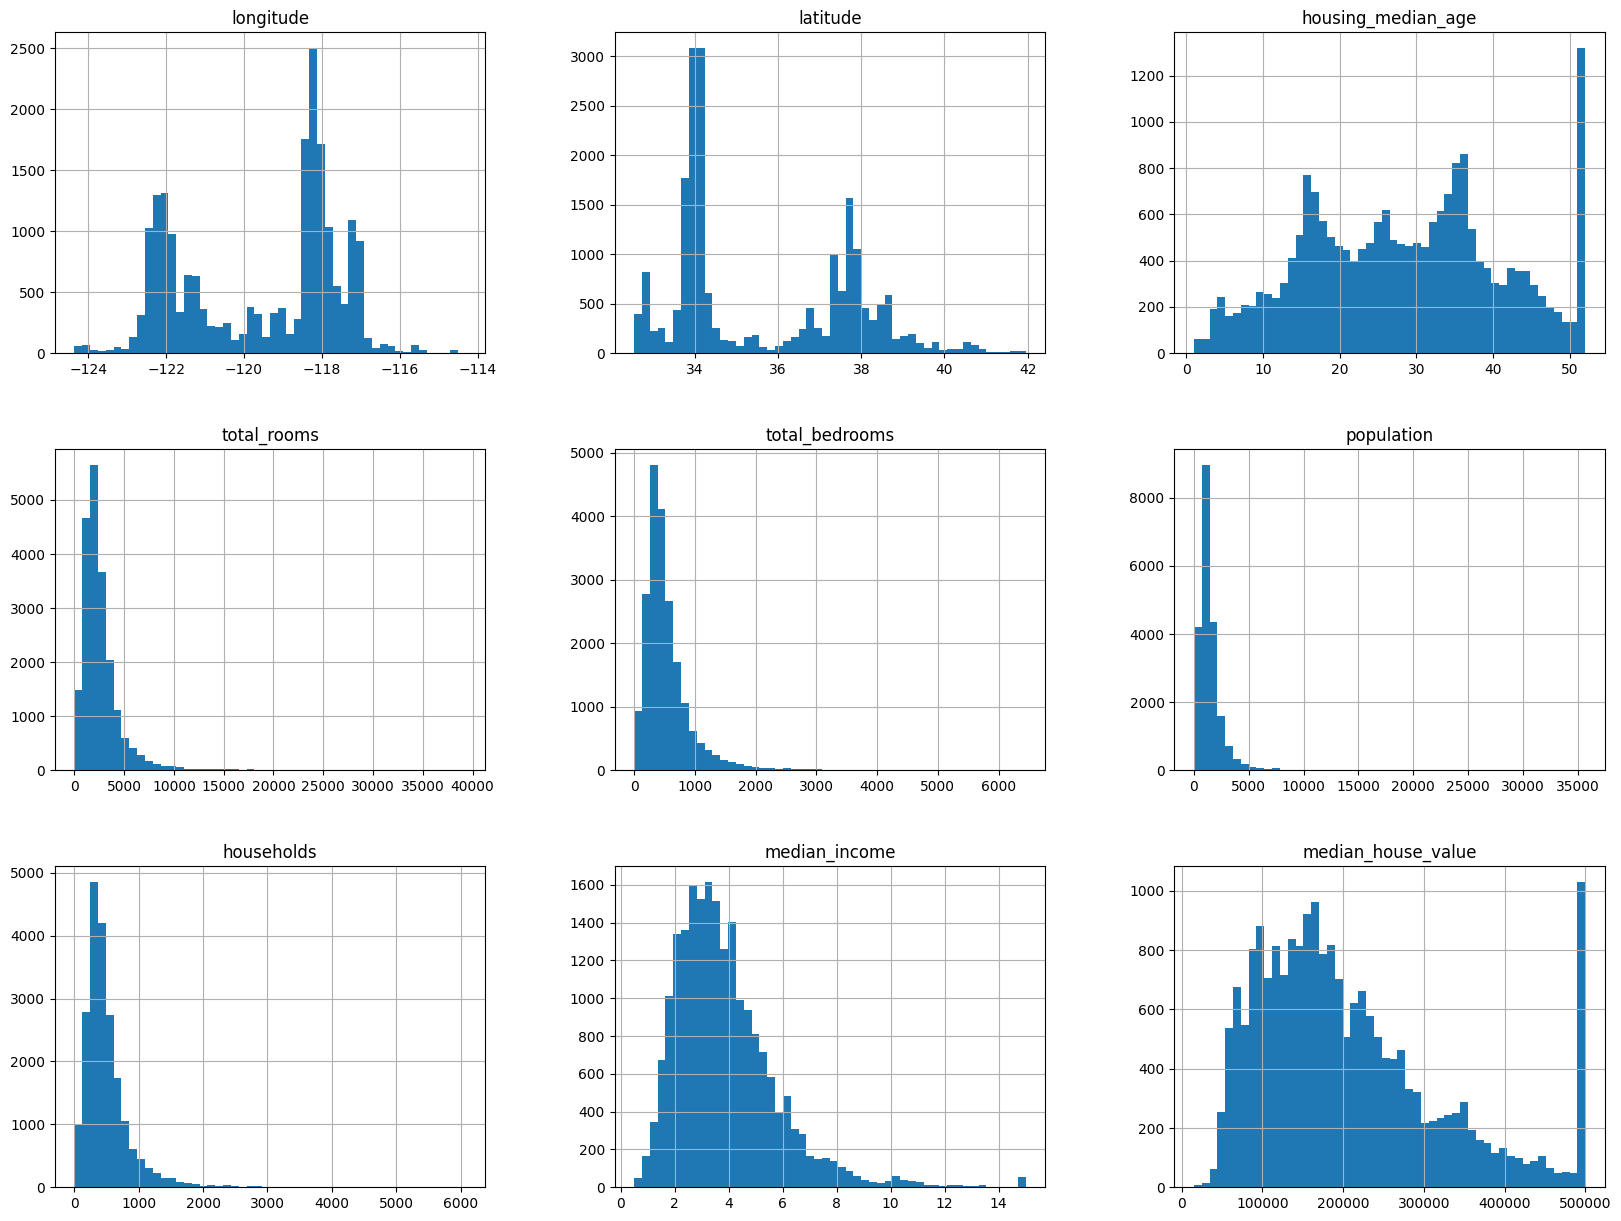

In [36]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()




In [37]:
# Dzielenie danych na zbiór treningowy i testowy ręcznie
import numpy as np

def split_train_test(data, test_ratio:float, seed: int):
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [38]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=2137)





In [39]:
print("training set length: ", len(train_set))
print("test set length: ", len(test_set))






training set length:  16512
test set length:  4128


In [40]:
income_cat = df['income_cat'] = pd.cut(df['median_income'], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[i for i in range(1, 6)])

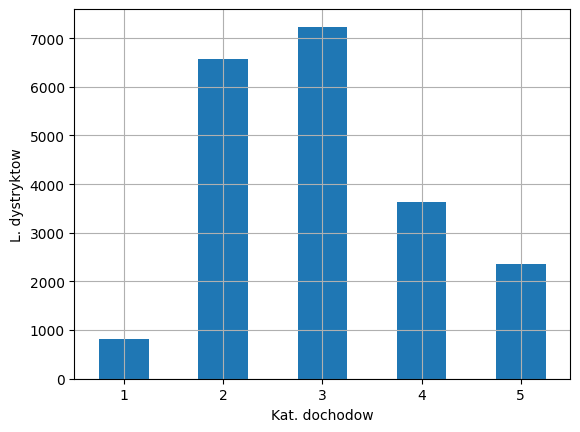

In [41]:
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Kat. dochodow")
plt.ylabel("L. dystryktow")
plt.show()

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2137)

strat_splits = [
    (
    df.iloc[train_index], 
    df.iloc[test_index]
    ) 
    for train_index, test_index 
        in splitter.split(df, df['income_cat'])
                ]




In [43]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, random_state=2137, stratify=df['income_cat'])

print(strat_train_set['income_cat'].value_counts() / len(strat_train_set))

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64


po co było to potrzebne:

## 1. Tworzenie kategorii dochodów (`income_cat`)

```python
income_cat = df['income_cat'] = pd.cut(df['median_income'], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[i for i in range(1, 6)])
```

**Po co to było:**
- `pd.cut()` dzieli ciągłą zmienną `median_income` na kategorie (bins)
- Tworzymy 5 kategorii dochodów:
  - Kategoria 1: 0-1.5 (bardzo niskie dochody)
  - Kategoria 2: 1.5-3.0 (niski dochód)
  - Kategoria 3: 3.0-4.5 (średni dochód)
  - Kategoria 4: 4.5-6.0 (wysoki dochód)
  - Kategoria 5: 6.0+ (bardzo wysokie dochody)

## 2. Problem z losowym podziałem danych

Wcześniej użyliśmy zwykłego `train_test_split()`, który **losowo** dzieli dane. To może prowadzić do problemu:

- Jeśli w zbiorze testowym będzie **nieproporcjonalnie** dużo lub mało danych z pewnych kategorii dochodów
- Model może być źle oceniony, bo testował się na danych, które nie reprezentują całej populacji

## 3. Stratified Sampling - rozwiązanie problemu

```python
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, random_state=2137, stratify=df['income_cat'])
```

**Po co `stratify=df['income_cat']`:**
- Zapewnia, że w zbiorze treningowym i testowym **proporcje kategorii dochodów są identyczne**
- Jeśli w całym zbiorze 35% to kategoria 3, to w zbiorze treningowym i testowym też będzie ~35% kategorii 3

## 4. Dlaczego robiliśmy "splitter znowu"?

W komórce 11 widzimy:
```python
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2137)
```

To jest **bardziej zaawansowana wersja** stratified sampling:
- `n_splits=10` - tworzy 10 różnych podziałów danych
- Każdy podział zachowuje proporcje kategorii dochodów
- Używane do **cross-validation** - testowania modelu na różnych kombinacjach danych

## Podsumowanie

**Cel:** Zapewnić, że model testuje się na danych reprezentatywnych dla całej populacji, a nie tylko na losowej próbce, która może być nieproporcjonalna.

**Metoda:** Stratified sampling - dzielenie danych tak, żeby proporcje ważnych kategorii (dochodów) były zachowane w zbiorach treningowym i testowym.

To jest **kluczowa praktyka** w machine learning - bez tego można otrzymać mylące wyniki modelu!

In [44]:
for st in (strat_train_set, strat_test_set):
    st.drop('income_cat', axis=1, inplace=True)






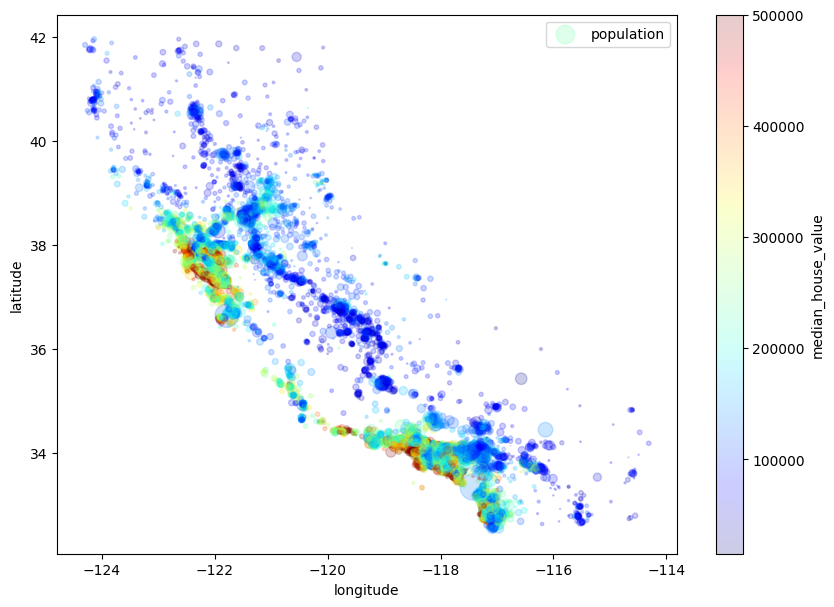

In [45]:
hs = strat_train_set.copy()
hs.plot(kind='scatter', x='longitude', y='latitude', alpha=0.2, s=hs['population']/100, label='population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()




median_house_value    1.000000
median_income         0.690217
total_rooms           0.132793
housing_median_age    0.105282
households            0.064513
total_bedrooms        0.048934
population           -0.024579
longitude            -0.050497
latitude             -0.141055
Name: median_house_value, dtype: float64


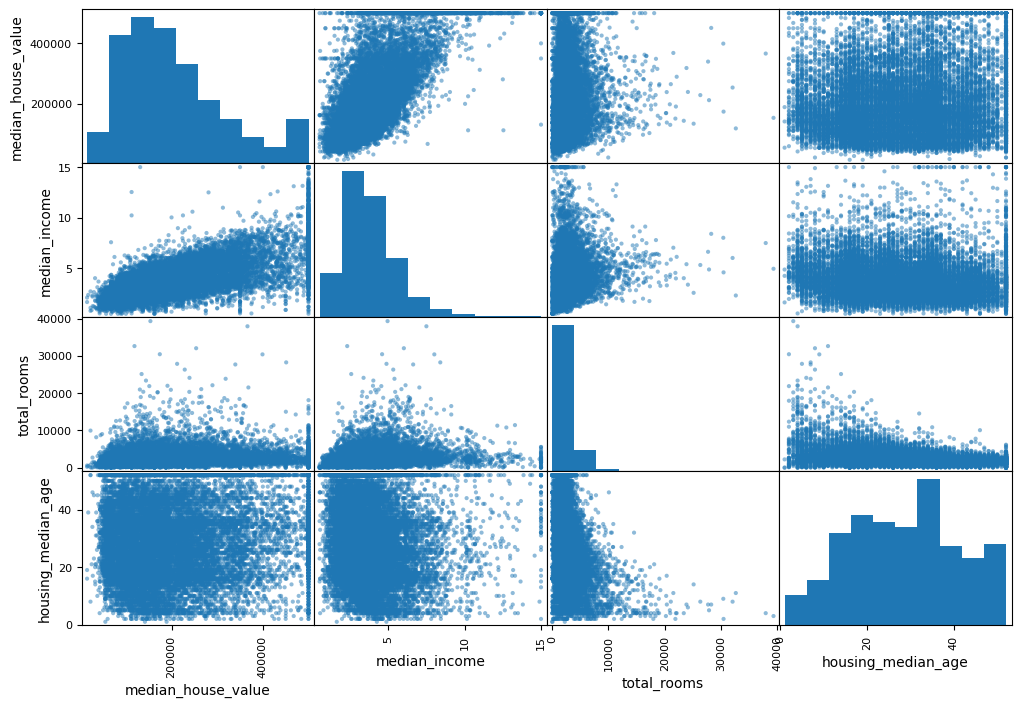

In [46]:
from pandas.plotting import scatter_matrix

corr_matrix = hs.corr(numeric_only=True)
cm_mhf_values = corr_matrix['median_house_value'].sort_values(ascending=False)

print(cm_mhf_values)

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(hs[attributes], figsize=(12, 8)) 
plt.show()


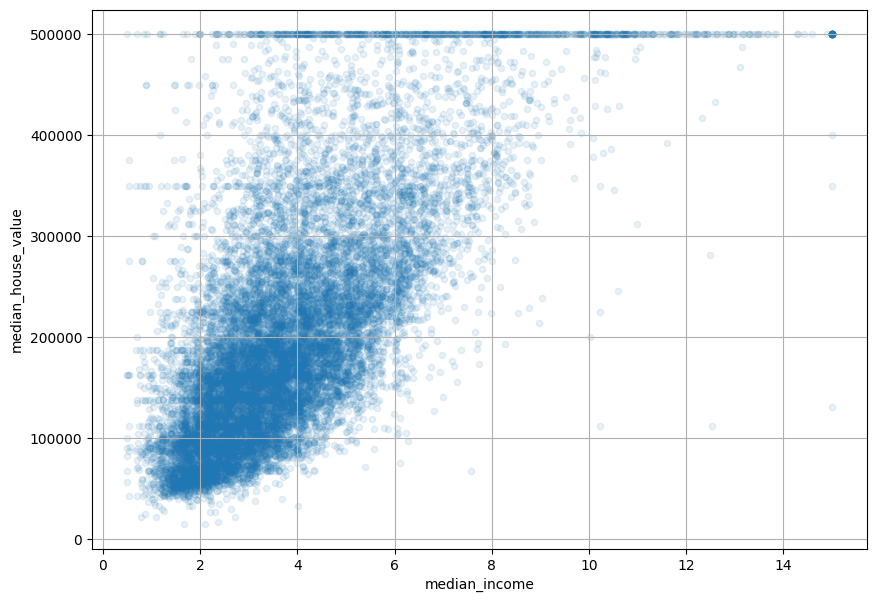

In [47]:
hs.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(10,7), grid=True)
plt.show()






In [48]:
hs['rooms_per_household'] = hs['total_rooms']/hs['households']
hs['bedrooms_per_room'] = hs['total_bedrooms']/hs['total_rooms']
hs['population_per_household'] = hs['population']/hs['households']

corr_matrix = hs.corr(numeric_only=True)
cm_mhf_values = corr_matrix['median_house_value'].sort_values(ascending=False)

print(cm_mhf_values)



median_house_value          1.000000
median_income               0.690217
rooms_per_household         0.154418
total_rooms                 0.132793
housing_median_age          0.105282
households                  0.064513
total_bedrooms              0.048934
population                 -0.024579
longitude                  -0.050497
population_per_household   -0.093423
latitude                   -0.141055
bedrooms_per_room          -0.257675
Name: median_house_value, dtype: float64


In [49]:
hs = strat_train_set.drop('median_house_value', axis=1)
hs_labels = strat_train_set['median_house_value'].copy()








In [50]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')


hs_num = hs.select_dtypes(include=[np.number])


imputer.fit(hs_num)


imputer.statistics_

print(hs_num.median().values)







[-118.51     34.26     29.     2122.      433.     1162.      409.
    3.5355]


In [51]:
X = imputer.transform(hs_num)

# zmienia na dataframe transformowane wartości
hs_tr = pd.DataFrame(X, columns=hs_num.columns, index=hs_num.index)









In [52]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
hs_cat_encoded = ordinal_encoder.fit_transform(hs[['ocean_proximity']])

print(hs_cat_encoded[:10])
ordinal_encoder.categories_

# to nie jest najlepsze podejście, bo model może przypisać kategorii 0 do wartości 1.0, a 4 do 3.0

# wiec lepiej użyć OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
hs_cat_encoded = one_hot_encoder.fit_transform(hs[['ocean_proximity']]).toarray()

print(hs_cat_encoded)














[[0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
one_hot_encoder.categories_
one_hot_encoder.feature_names_in_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]